2025-03-25 11:09:48,423 - INFO - Starting LUNA flash crash spoofing detection model with enhanced processing
2025-03-25 11:09:48,425 - INFO - Loading data from full_channel_sim.csv
2025-03-25 11:09:49,043 - INFO - Data loaded successfully with shape: (532404, 18)
2025-03-25 11:09:49,044 - INFO - Starting data preprocessing...
2025-03-25 11:09:50,064 - INFO - Converted 'price' to numeric. NaN count: 5882
2025-03-25 11:09:50,095 - INFO - Converted 'size' to numeric. NaN count: 326450
2025-03-25 11:09:50,122 - INFO - Converted 'remaining_size' to numeric. NaN count: 209345
2025-03-25 11:09:50,139 - INFO - Filled NaN in 'size' with median: 100.0
2025-03-25 11:09:50,145 - INFO - Filled NaN in 'price' with median: 1.23
2025-03-25 11:09:50,150 - INFO - Filled NaN in 'remaining_size' with median: 100.0
Exception in thread Thread-8:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/opt/anaconda3/lib/pyt


Model Performance Summary:
Accuracy: 0.7380
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Detected Spoofs: 6550


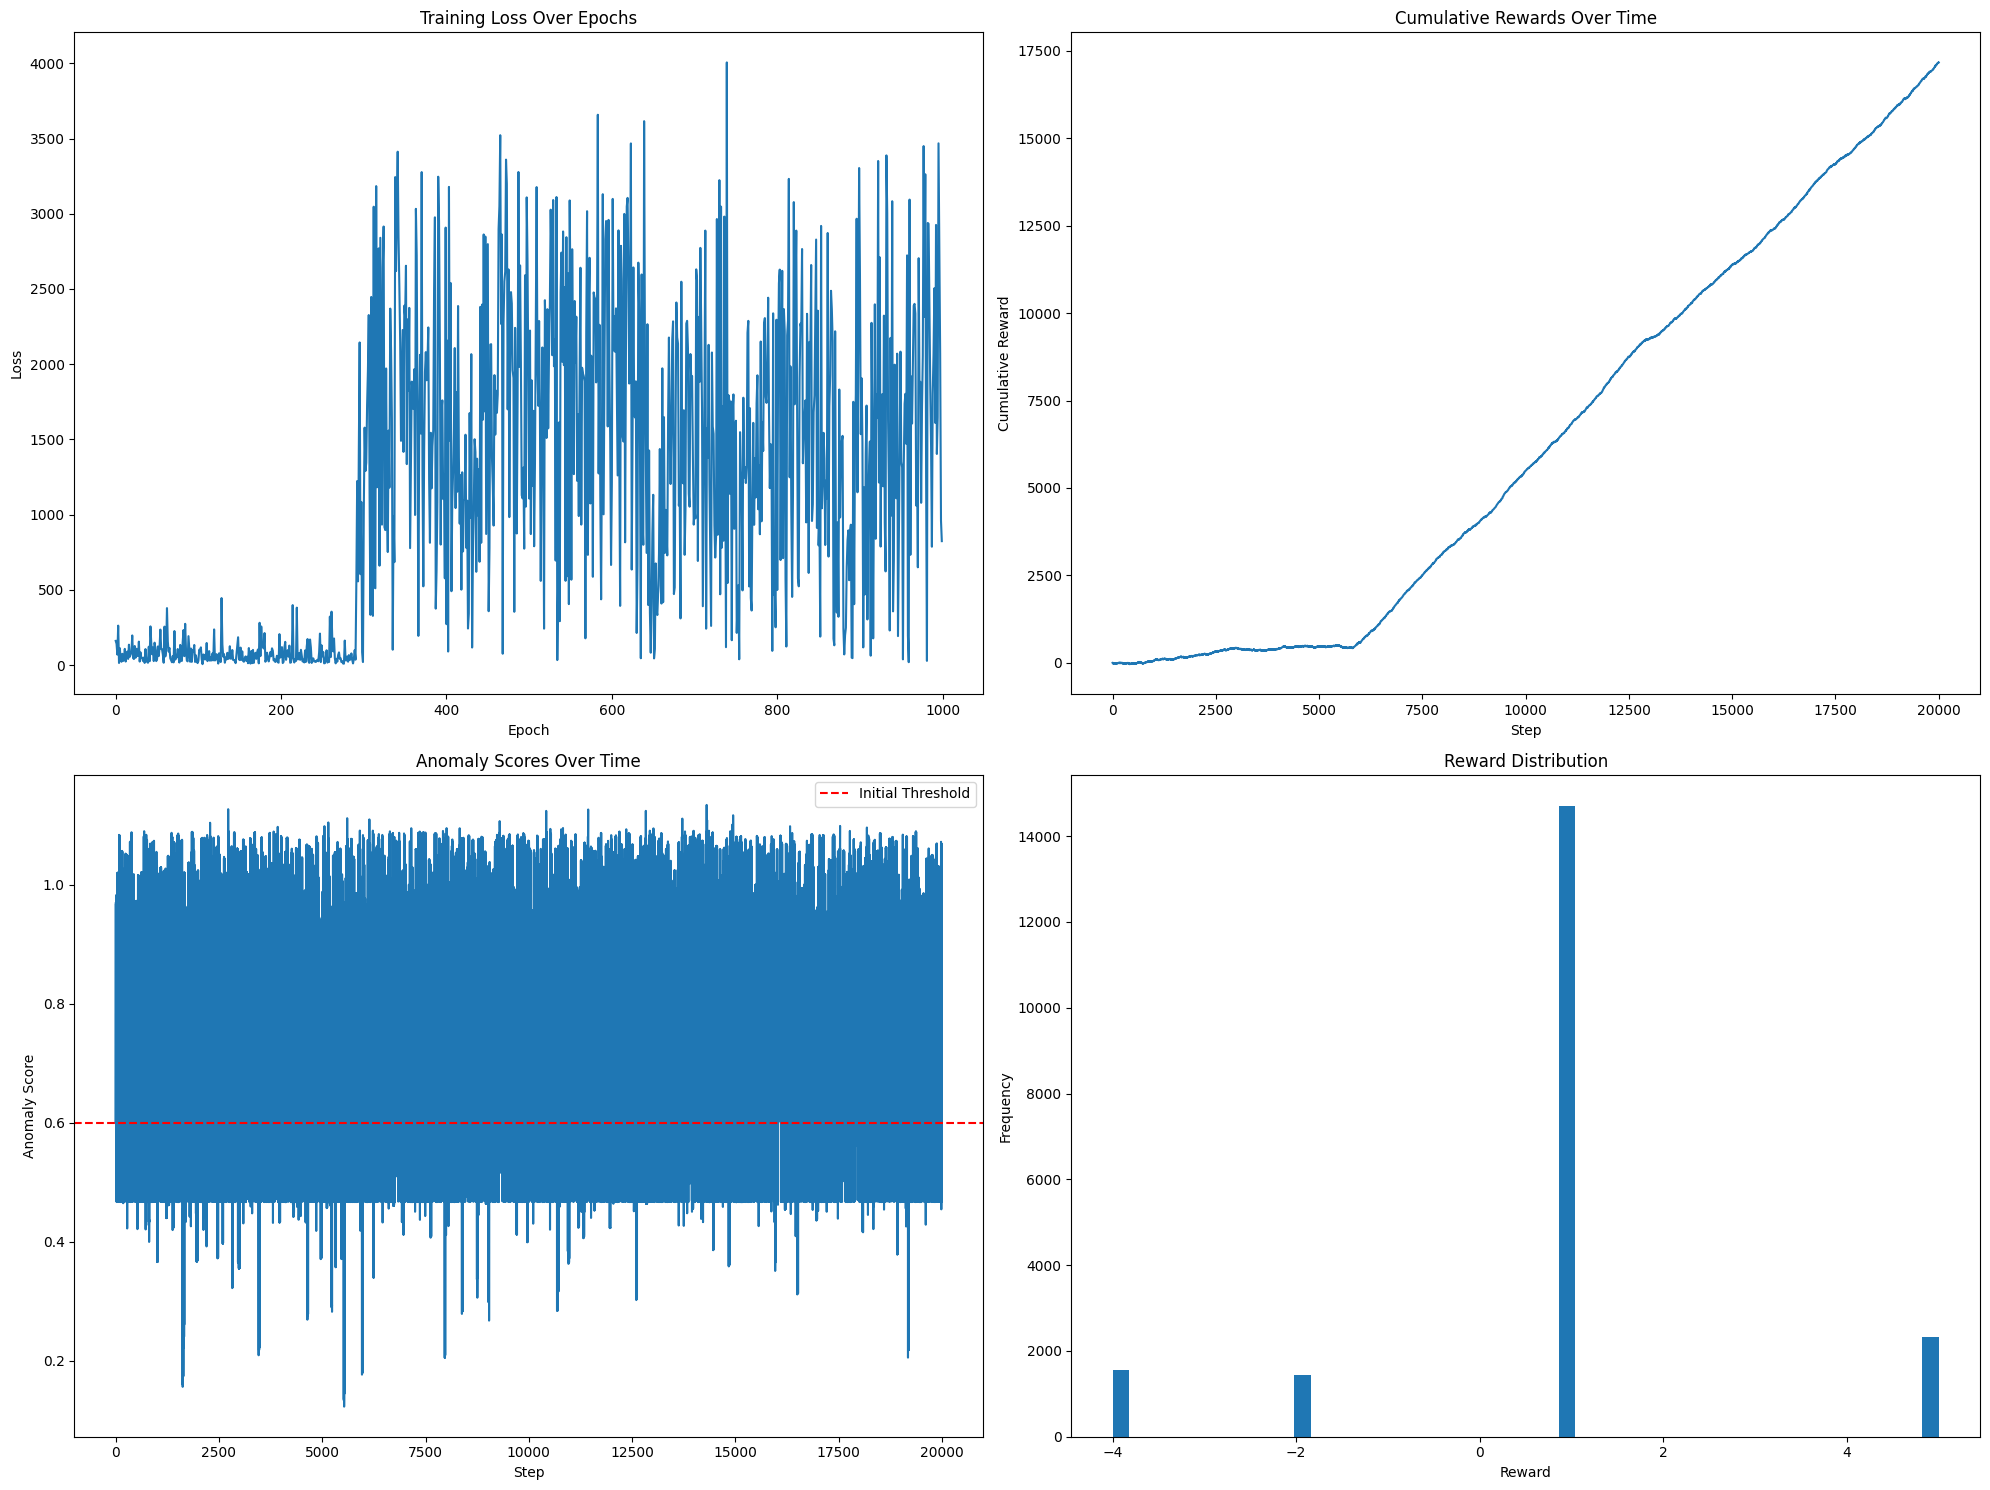

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import deque
import datetime
import json
import os
import time
import threading
import pickle
import itertools
import traceback
import logging
from joblib import Parallel, delayed
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("luna_spoofing_detector.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger("luna_spoofing_detector")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class TimeoutError(Exception):
    """Exception raised when an operation times out."""
    pass

class timeout:
    """Context manager for timeout functionality."""
    def __init__(self, seconds):
        self.seconds = seconds
        self.timer = None
    
    def handle_timeout(self):
        raise TimeoutError("Operation timed out")
    
    def __enter__(self):
        self.timer = threading.Timer(self.seconds, self.handle_timeout)
        self.timer.daemon = True  # Allow program to exit even if timer is alive
        self.timer.start()
        return self
    
    def __exit__(self, type, value, traceback):
        if self.timer:
            self.timer.cancel()

class Config:
    """Configuration parameters optimized for LUNA flash crash data."""
    
    # Data parameters
    TRAIN_SPLIT = 0.7
    
    # Market Environment parameters
    HISTORY_WINDOW = 10  # Reduced from 15 to capture rapid spoofing patterns
    SPOOFING_THRESHOLD_INITIAL = 0.6  # Lowered from 0.85 to increase detection
    
    # Identify peak crash hours (typically highest volatility periods)
    CRASH_HOURS = [18, 19]  # Hours when flash crash was most intense (6-7pm)
    
    # PPO parameters optimized for LUNA dataset
    PPO_CONFIG = {
        'learning_rate': 1e-3,      # Increased from 5e-4
        'n_steps': 200,             # Reduced from 250 for stability
        'batch_size': 64,           # Kept as is
        'n_epochs': 10,             # Reduced from 15 for faster iterations
        'gamma': 0.99,              # Kept as is
        'gae_lambda': 0.95,         # Kept as is
        'clip_range': 0.2,          # Kept as is
        'ent_coef': 0.03,           # Increased from 0.01 to encourage exploration
        'vf_coef': 0.5,             # Kept as is
        'max_grad_norm': 0.5        # Kept as is
    }
    
    # Criteria for identifying valid spoofing behavior
    SPOOFING_CRITERIA = {
        'min_order_size': 50.0,           # Reduced from 100.0
        'quick_cancel_seconds': 2.0,      # Increased from 1.0
        'cancel_to_trade_ratio': 0.8,     # Reduced from 0.9
        'price_to_mid_threshold': 0.1,    # Increased from 0.05
        'min_anomaly_score': 0.6,         # Reduced from 0.85
    }
    
    # Feature weights for anomaly score calculation
    FEATURE_WEIGHTS = {
        'order_flow_imbalance': 0.20,        # Increased from 0.15
        'cancel_to_received_ratio': 0.30,     # Increased from 0.25
        'time_since_last_cancel': 0.10,
        'price_5_std': 0.08,                  # Increased from 0.05
        'price_10_std': 0.08,                 # Increased from 0.05
        'price_15_std': 0.08,                 # Increased from 0.05
        'size_5_var': 0.08,                   # Increased from 0.05
        'size_10_var': 0.08,                  # Increased from 0.05
        'size_15_var': 0.08,                  # Increased from 0.05
        'spread': 0.15,                       # Increased from 0.10
        'last_size_5_var': 0.08,              # Increased from 0.05
        'last_size_10_var': 0.08,             # Increased from 0.05
        'hour_of_day': 0.10,
        'hour_15': 0.01,
        'hour_16': 0.02,
        'hour_17': 0.03,
        'hour_18': 0.15,                      # Increased from 0.08 for peak crash hour
        'hour_19': 0.15,                      # Increased from 0.08 for peak crash hour
        'is_canceled': 0.25,                  # Increased from 0.15
        'quick_cancel': 0.30,                 # Increased from 0.20
        'remaining_size_change': 0.15         # Increased from 0.10
    }

def _chunked_iterator(iterable, chunk_size):
    """Helper function to process iterables in chunks to avoid performance issues."""
    iterator = iter(iterable)
    while True:
        chunk = list(itertools.islice(iterator, chunk_size))
        if not chunk:
            break
        yield chunk

class DataPreprocessor:
    """Class for loading and preprocessing LUNA LOB data."""
    
    def __init__(self, file_path=None):
        self.file_path = file_path
        self.scaler = MinMaxScaler()
        self.data = None
        
    def load_data(self):
        """Load LUNA data from CSV or JSON file with timeout protection."""
        try:
            if self.file_path is None:
                # If no file path provided, try to find it
                for path in ['full_channel_sim.csv', 'luna_data.csv', 'luna_lob_data.csv']:
                    if os.path.exists(path):
                        self.file_path = path
                        break
                
                # If still no file path found, raise an error
                if self.file_path is None:
                    logger.error("No data file found. Please provide a valid file path.")
                    raise FileNotFoundError("No data file found")
            
            if not os.path.exists(self.file_path):
                logger.error(f"File not found: {self.file_path}")
                raise FileNotFoundError(f"File not found: {self.file_path}")
            
            logger.info(f"Loading data from {self.file_path}")
            
            # Use timeout for file loading (30 seconds)
            with timeout(30):
                if self.file_path.endswith('.json'):
                    # Load JSON data
                    with open(self.file_path, 'r') as f:
                        data = json.load(f)
                    self.data = pd.json_normalize(data)
                else:
                    # Load CSV data
                    self.data = pd.read_csv(self.file_path)
            
            logger.info(f"Data loaded successfully with shape: {self.data.shape}")
            
            # If data is very large, sample it to improve processing speed
            if len(self.data) > 600000:
                logger.info(f"Data is very large. Sampling to 500,000 rows for performance.")
                self.data = self.data.sample(n=500000, random_state=42)
            
            return self.data
        except TimeoutError:
            logger.error("Timeout while loading data. Creating synthetic data instead.")
            self.data = create_synthetic_sample_data()
            return self.data
        except Exception as e:
            logger.error(f"Error loading data: {str(e)}")
            raise
    
    def preprocess_data(self, data=None):
        """Preprocess the LUNA LOB data with improved error handling."""
        if data is not None:
            self.data = data
        
        if self.data is None:
            logger.error("No data to preprocess. Call load_data() first or provide data.")
            raise ValueError("No data to preprocess")
        
        logger.info("Starting data preprocessing...")
        
        try:
            # Make a copy to avoid modifying the original
            self.data = self.data.copy()
            
            # Handle NaN values in the dataframe
            self.data = self.data.fillna('')
            
            # Convert time column to datetime if it exists
            if 'time' in self.data.columns:
                try:
                    self.data['time'] = pd.to_datetime(self.data['time'], errors='coerce')
                    
                    # Handle rows where time couldn't be converted
                    if self.data['time'].isna().any():
                        logger.warning(f"Found {self.data['time'].isna().sum()} rows with invalid time values")
                    
                    # Extract hour of day
                    self.data['hour_of_day'] = self.data['time'].dt.hour.fillna(-1).astype(int)
                    
                    # One-hot encode hour of day for specific hours during LUNA crash
                    for hour in range(15, 20):  # Hours 15-19 (3pm-7pm)
                        self.data[f'hour_{hour}'] = (self.data['hour_of_day'] == hour).astype(int)
                except Exception as e:
                    logger.warning(f"Error processing time column: {str(e)}")
                    # Create a default hour_of_day column
                    self.data['hour_of_day'] = -1
                    for hour in range(15, 20):
                        self.data[f'hour_{hour}'] = 0
            else:
                logger.warning("No 'time' column found in data")
                # Create default time-related columns
                self.data['hour_of_day'] = -1
                for hour in range(15, 20):
                    self.data[f'hour_{hour}'] = 0
            
            # Ensure numeric columns are properly typed
            numeric_cols = ['price', 'size', 'remaining_size']
            for col in numeric_cols:
                if col in self.data.columns:
                    self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
                    logger.info(f"Converted '{col}' to numeric. NaN count: {self.data[col].isna().sum()}")
                else:
                    logger.warning(f"Column '{col}' not found. Adding with default values.")
                    self.data[col] = 0.0
            
            # Handle missing values in numeric columns
            for column in self.data.select_dtypes(include=[np.number]).columns:
                if self.data[column].isna().any():
                    median_value = self.data[column].median()
                    if np.isnan(median_value):  # If median is also NaN
                        median_value = 0.0
                    self.data[column] = self.data[column].fillna(median_value)
                    logger.info(f"Filled NaN in '{column}' with median: {median_value}")
            
            # Flag for canceled orders - crucial for spoofing detection
            if 'reason' in self.data.columns:
                self.data['is_canceled'] = (self.data['reason'] == 'canceled').astype(int)
            else:
                logger.warning("No 'reason' column found. Adding 'is_canceled' with default values.")
                self.data['is_canceled'] = 0  # Default if 'reason' column doesn't exist
            
            # Calculate time to cancellation for each order (with timeout protection)
            if 'order_id' in self.data.columns and 'time' in self.data.columns:
                try:
                    # Use a timeout to prevent hanging (5 seconds)
                    with timeout(5):
                        # Create dictionaries to track order lifecycle
                        order_times = {}
                        cancel_times = {}
                        
                        # Filter out rows with NaT in time column
                        valid_data = self.data[self.data['time'].notna()].copy()
                        
                        # Extract order received and cancellation times
                        for _, row in valid_data.iterrows():
                            order_id = row['order_id']
                            if pd.isna(order_id) or order_id == '':
                                continue
                            
                            if row.get('type') == 'received':
                                order_times[order_id] = row['time']
                            
                            if row.get('type') == 'done' and row.get('reason') == 'canceled':
                                cancel_times[order_id] = row['time']
                        
                        # Calculate time to cancellation for each order
                        time_to_cancel = {}
                        for order_id in order_times:
                            if order_id in cancel_times:
                                time_to_cancel[order_id] = (cancel_times[order_id] - order_times[order_id]).total_seconds()
                        
                        # Map time to cancellation back to data
                        self.data['time_to_cancel'] = self.data['order_id'].map(lambda x: time_to_cancel.get(x, np.nan))
                        
                        # Flag for quick cancellations (within 1 second) - potential spoofing indicator
                        self.data['quick_cancel'] = ((self.data['time_to_cancel'] < 1.0) & 
                                                  (self.data['time_to_cancel'] > 0)).astype(int)
                        
                        logger.info(f"Calculated time to cancellation for {len(time_to_cancel)} orders")
                except (TimeoutError, Exception) as e:
                    logger.warning(f"Could not calculate time to cancellation: {str(e)}")
                    # Provide default values
                    self.data['time_to_cancel'] = np.nan
                    self.data['quick_cancel'] = 0
            else:
                logger.warning("Missing required columns for time to cancellation calculation")
                self.data['time_to_cancel'] = np.nan
                self.data['quick_cancel'] = 0
            
            # Calculate remaining size change - important for spoofing detection
            if 'remaining_size' in self.data.columns and 'order_id' in self.data.columns:
                try:
                    # Use a timeout to prevent hanging (5 seconds)
                    with timeout(5):
                        # Group by order_id and calculate difference in remaining_size
                        if any(pd.isna(self.data['order_id'])):
                            logger.warning("Found NaN values in order_id. Filtering them out.")
                            valid_data = self.data[~pd.isna(self.data['order_id'])].copy()
                            valid_data['remaining_size_change'] = valid_data.groupby('order_id')['remaining_size'].diff()
                            self.data['remaining_size_change'] = np.nan
                            # Update only valid entries
                            for idx, row in valid_data.iterrows():
                                if idx in self.data.index:
                                    self.data.at[idx, 'remaining_size_change'] = row['remaining_size_change']
                        else:
                            self.data['remaining_size_change'] = self.data.groupby('order_id')['remaining_size'].diff()
                        
                        logger.info("Calculated remaining size change")
                except (TimeoutError, Exception) as e:
                    logger.warning(f"Could not calculate remaining size change: {str(e)}")
                    self.data['remaining_size_change'] = 0
            else:
                logger.warning("Missing required columns for remaining size change calculation")
                self.data['remaining_size_change'] = 0
            
            # One-hot encode categorical features
            categorical_features = ['type', 'side', 'reason']
            for feature in categorical_features:
                if feature in self.data.columns:
                    try:
                        dummies = pd.get_dummies(self.data[feature], prefix=feature)
                        self.data = pd.concat([self.data, dummies], axis=1)
                        logger.info(f"One-hot encoded '{feature}'")
                    except Exception as e:
                        logger.warning(f"Error one-hot encoding {feature}: {str(e)}")
                        # Add empty dummy columns
                        if feature == 'type':
                            for col_type in ['received', 'open', 'done']:
                                self.data[f'{feature}_{col_type}'] = 0
                        elif feature == 'side':
                            self.data['side_buy'] = 0
                            self.data['side_sell'] = 0
                        elif feature == 'reason':
                            self.data['reason_canceled'] = 0
                            self.data['reason_filled'] = 0
                else:
                    logger.warning(f"'{feature}' column not found for one-hot encoding")
                    # Add empty dummy columns
                    if feature == 'type':
                        for col_type in ['received', 'open', 'done']:
                            self.data[f'{feature}_{col_type}'] = 0
                    elif feature == 'side':
                        self.data['side_buy'] = 0
                        self.data['side_sell'] = 0
                    elif feature == 'reason':
                        self.data['reason_canceled'] = 0
                        self.data['reason_filled'] = 0
            
            # Create flag for large orders (potential spoofing)
            if 'size' in self.data.columns:
                try:
                    size_mean = self.data['size'].mean()
                    size_std = self.data['size'].std()
                    # Flag orders that are significantly larger than average (2+ std deviations)
                    self.data['large_order'] = (self.data['size'] > (size_mean + 2 * size_std)).astype(int)
                    logger.info(f"Flagged large orders (>{size_mean + 2*size_std:.4f})")
                except Exception as e:
                    logger.warning(f"Error flagging large orders: {str(e)}")
                    self.data['large_order'] = 0
            else:
                self.data['large_order'] = 0
            
            # Normalize numeric features
            try:
                numeric_cols = self.data.select_dtypes(include=[np.number]).columns
                if len(numeric_cols) > 0:
                    # Fill NaN before normalization
                    numeric_data = self.data[numeric_cols].fillna(0)
                    self.data[numeric_cols] = self.scaler.fit_transform(numeric_data)
                    logger.info("Normalized numeric features")
                else:
                    logger.warning("No numeric columns found for normalization")
            except Exception as e:
                logger.warning(f"Error normalizing numeric features: {str(e)}")
                # Recover by setting all numeric values to scaled range 0-1
                for col in self.data.select_dtypes(include=[np.number]).columns:
                    col_min = self.data[col].min()
                    col_max = self.data[col].max()
                    if col_max > col_min:
                        self.data[col] = (self.data[col] - col_min) / (col_max - col_min)
                    else:
                        self.data[col] = 0
            
            # Ensure all columns are filled (no NaN values)
            self.data = self.data.fillna(0)
            
            logger.info(f"Data preprocessing completed. Shape: {self.data.shape}")
            return self.data
            
        except Exception as e:
            logger.error(f"Error in preprocessing: {str(e)}\n{traceback.format_exc()}")
            # Try to recover with simplified preprocessing
            return self._simplified_preprocessing()
    
    def _simplified_preprocessing(self):
        """Simplified preprocessing when the full preprocessing fails."""
        logger.info("Attempting simplified preprocessing...")
        
        try:
            # Make a copy of original data
            df = self.data.copy() if self.data is not None else pd.DataFrame()
            
            # If DataFrame is empty, return empty
            if df.empty:
                return df
                
            # Ensure basic columns exist
            for col in ['price', 'size', 'remaining_size']:
                if col not in df.columns:
                    df[col] = 0.0
                else:
                    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
            
            # Add minimal required fields
            if 'reason' in df.columns:
                df['is_canceled'] = (df['reason'] == 'canceled').astype(int)
            else:
                df['is_canceled'] = 0
                
            df['quick_cancel'] = 0
            df['large_order'] = 0
            df['remaining_size_change'] = 0
            df['hour_of_day'] = 0
            
            # Add hour columns
            for hour in range(15, 20):
                df[f'hour_{hour}'] = 0
            
            # Add categorical columns
            for prefix in ['type', 'side', 'reason']:
                for suffix in ['received', 'open', 'done', 'buy', 'sell', 'canceled', 'filled']:
                    col = f"{prefix}_{suffix}"
                    if col not in df.columns:
                        df[col] = 0
            
            # Fill any remaining NaN values
            df = df.fillna(0)
            
            logger.info(f"Simplified preprocessing completed. Shape: {df.shape}")
            self.data = df
            return df
            
        except Exception as e:
            logger.error(f"Error in simplified preprocessing: {str(e)}")
            # Return empty DataFrame as last resort
            return pd.DataFrame()

class FeatureEngineer:
    """Class for engineering features specific to LUNA spoofing detection."""
    
    def __init__(self, data=None):
        self.data = data
        
    def engineer_features(self, data=None):
        """Engineer features with timeout protection and error handling."""
        if data is not None:
            self.data = data
        
        if self.data is None or self.data.empty:
            logger.error("No data provided for feature engineering")
            raise ValueError("No data provided for feature engineering")
        
        try:
            # Make a copy to avoid modifying the original
            self.data = self.data.copy()
            
            logger.info("Starting feature engineering...")
            
            # Use timeout to prevent hanging (30 seconds)
            with timeout(30):
                self._engineer_core_features()
            
            return self.data
            
        except TimeoutError:
            logger.warning("Feature engineering timed out. Using simplified features.")
            return self._simplified_feature_engineering()
        except Exception as e:
            logger.error(f"Error in feature engineering: {str(e)}\n{traceback.format_exc()}")
            return self._simplified_feature_engineering()
    
    def _engineer_core_features(self):
        """Core feature engineering with error handling for each feature group."""
        try:
            # Calculate rolling statistics for price movements
            self._engineer_price_features()
            
            # Calculate rolling statistics for size movements
            self._engineer_size_features()
            
            # Calculate order flow imbalance (OFI)
            self._engineer_order_flow_features()
            
            # Add cancellation ratio
            self._engineer_cancellation_features()
            
            # Calculate market spread
            self._engineer_spread_features()
            
            # Calculate the time-since-last-cancel feature
            self._engineer_time_features()
            
            # Calculate last size variance
            self._engineer_last_size_features()
            
            # Calculate cancellation clusters
            self._engineer_cancellation_clusters()
            
            # Add emphasis to crash hours
            self._engineer_crash_hour_features()
            
            # Fill NaN values resulting from rolling calculations
            self.data = self.data.fillna(0)
            
            logger.info(f"Feature engineering completed. Features: {self.data.shape[1]}")
            
        except Exception as e:
            logger.error(f"Error in core feature engineering: {str(e)}")
            raise
            
    def _engineer_price_features(self):
        """Engineer price-related features."""
        if 'price' in self.data.columns:
            for window in [5, 10, 15]:
                try:
                    # Rolling mean, standard deviation, and variance of price
                    self.data[f'price_{window}_mean'] = self.data['price'].rolling(window=window, min_periods=1).mean()
                    self.data[f'price_{window}_std'] = self.data['price'].rolling(window=window, min_periods=1).std()
                    self.data[f'price_{window}_var'] = self.data['price'].rolling(window=window, min_periods=1).var()
                except Exception as e:
                    logger.warning(f"Error calculating price rolling stats for window {window}: {str(e)}")
                    self.data[f'price_{window}_mean'] = self.data['price']
                    self.data[f'price_{window}_std'] = 0
                    self.data[f'price_{window}_var'] = 0
        else:
            logger.warning("No 'price' column found. Adding default values for rolling stats.")
            for window in [5, 10, 15]:
                self.data[f'price_{window}_mean'] = 0
                self.data[f'price_{window}_std'] = 0
                self.data[f'price_{window}_var'] = 0
    
    def _engineer_size_features(self):
        """Engineer size-related features."""
        if 'size' in self.data.columns:
            for window in [5, 10, 15]:
                try:
                    # Rolling mean, standard deviation, and variance of size
                    self.data[f'size_{window}_mean'] = self.data['size'].rolling(window=window, min_periods=1).mean()
                    self.data[f'size_{window}_std'] = self.data['size'].rolling(window=window, min_periods=1).std()
                    self.data[f'size_{window}_var'] = self.data['size'].rolling(window=window, min_periods=1).var()
                except Exception as e:
                    logger.warning(f"Error calculating size rolling stats for window {window}: {str(e)}")
                    self.data[f'size_{window}_mean'] = self.data['size']
                    self.data[f'size_{window}_std'] = 0
                    self.data[f'size_{window}_var'] = 0
        else:
            logger.warning("No 'size' column found. Adding default values for rolling stats.")
            for window in [5, 10, 15]:
                self.data[f'size_{window}_mean'] = 0
                self.data[f'size_{window}_std'] = 0
                self.data[f'size_{window}_var'] = 0
    
    def _engineer_order_flow_features(self):
        """Engineer order flow imbalance features."""
        if 'size' in self.data.columns:
            try:
                # Determine the side multiplier (1 for buy, -1 for sell)
                if 'side_buy' in self.data.columns and 'side_sell' in self.data.columns:
                    self.data['signed_size'] = self.data['size'] * (2 * self.data['side_buy'] - 1)
                elif 'side' in self.data.columns:
                    # Alternative calculation if side_buy is not available
                    self.data['signed_size'] = self.data.apply(
                        lambda row: row['size'] if str(row.get('side')).lower() == 'buy' else -row['size'], axis=1
                    )
                else:
                    # Default to random if side information is not available
                    logger.warning("No side information found for OFI calculation. Using random values.")
                    np.random.seed(42)  # For reproducibility
                    self.data['signed_size'] = self.data['size'] * np.random.choice([-1, 1], size=len(self.data))
                
                # Calculate order flow imbalance for different windows
                for window in [5, 10, 15]:
                    self.data[f'order_flow_imbalance_{window}'] = self.data['signed_size'].rolling(window=window, min_periods=1).sum()
                
                # Use the 15-window as the main OFI
                if 'order_flow_imbalance_15' in self.data.columns:
                    self.data['order_flow_imbalance'] = self.data['order_flow_imbalance_15']
                else:
                    logger.warning("'order_flow_imbalance_15' not calculated. Using default OFI.")
                    self.data['order_flow_imbalance'] = 0
                
                logger.info("Calculated order flow imbalance")
            except Exception as e:
                logger.warning(f"Error calculating order flow imbalance: {str(e)}")
                self.data['order_flow_imbalance'] = 0
                for window in [5, 10, 15]:
                    self.data[f'order_flow_imbalance_{window}'] = 0
        else:
            logger.warning("No 'size' column found for OFI calculation")
            self.data['order_flow_imbalance'] = 0
            for window in [5, 10, 15]:
                self.data[f'order_flow_imbalance_{window}'] = 0
    
    def _engineer_cancellation_features(self):
        """Engineer cancellation-related features."""
        try:
            # Ensure we have the necessary columns, otherwise create them
            for type_col in ['type_received', 'reason_canceled']:
                if type_col not in self.data.columns:
                    base_col = type_col.split('_')[0]
                    suffix = type_col.split('_')[1]
                    if f'{base_col}_{suffix}' not in self.data.columns:
                        logger.warning(f"Column {type_col} not found. Creating with default values.")
                        self.data[type_col] = 0
            
            # Calculate cancellation ratio: ratio of canceled orders to received orders
            # Ensure denominator is never zero by adding 1 (type_received_adjusted)
            self.data['type_received_adjusted'] = self.data['type_received'] + 1
            self.data['cancel_to_received_ratio'] = self.data['reason_canceled'] / self.data['type_received_adjusted']
            logger.info("Calculated cancellation ratio")
        except Exception as e:
            logger.warning(f"Error calculating cancellation ratio: {str(e)}")
            self.data['cancel_to_received_ratio'] = 0
    
    def _engineer_spread_features(self):
        """Engineer market spread features."""
        if 'best_ask' in self.data.columns and 'best_bid' in self.data.columns:
            try:
                self.data['spread'] = self.data['best_ask'] - self.data['best_bid']
                # Handle negative spread (data error)
                self.data.loc[self.data['spread'] < 0, 'spread'] = 0
                logger.info("Calculated market spread from best_ask and best_bid")
            except Exception as e:
                logger.warning(f"Error calculating market spread: {str(e)}")
                self.data['spread'] = 0
        else:
            # Use price as approximate spread if best_ask/best_bid not available
            self.data['spread'] = self.data['price'] * 0.01  # 1% of price as default spread
            logger.info("Used price as approximate market spread")
    
    def _engineer_time_features(self):
        """Engineer time-related features."""
        try:
            if 'is_canceled' in self.data.columns:
                cancel_col = 'is_canceled'
            elif 'reason_canceled' in self.data.columns:
                cancel_col = 'reason_canceled'
            else:
                logger.warning("No cancellation column found for time-since-last-cancel")
                cancel_col = None
                
            if cancel_col:
                self.data['last_cancel'] = self.data[cancel_col].shift(1).fillna(0)
                self.data['time_since_last_cancel'] = 0.0
                
                if 'time' in self.data.columns and pd.api.types.is_datetime64_any_dtype(self.data['time']):
                    self.data['time_diff'] = self.data['time'].diff().dt.total_seconds().fillna(0)
                    # If last record was a cancel, add the time difference
                    self.data.loc[self.data['last_cancel'] == 1, 'time_since_last_cancel'] = self.data['time_diff']
                    # Calculate running sum to get time since last cancel
                    self.data['time_since_last_cancel'] = self.data['time_since_last_cancel'].cumsum()
                    # Reset to 0 when a cancel occurs
                    self.data.loc[self.data[cancel_col] == 1, 'time_since_last_cancel'] = 0
                    logger.info("Calculated time since last cancel")
                else:
                    logger.warning("No valid time column for time-since-last-cancel calculation")
                    self.data['time_since_last_cancel'] = 0
            else:
                self.data['time_since_last_cancel'] = 0
        except Exception as e:
            logger.warning(f"Error calculating time since last cancel: {str(e)}")
            self.data['time_since_last_cancel'] = 0
    
    def _engineer_last_size_features(self):
        """Engineer last size variance features."""
        if 'remaining_size' in self.data.columns:
            for window in [5, 10, 15]:
                try:
                    self.data[f'last_size_{window}_var'] = self.data['remaining_size'].rolling(window=window, min_periods=1).var()
                    logger.info(f"Calculated last size variance for window {window}")
                except Exception as e:
                    logger.warning(f"Error calculating last size variance for window {window}: {str(e)}")
                    self.data[f'last_size_{window}_var'] = 0
        else:
            logger.warning("No 'remaining_size' column for last size variance calculation")
            for window in [5, 10, 15]:
                self.data[f'last_size_{window}_var'] = 0
    
    def _engineer_cancellation_clusters(self):
        """Engineer cancellation cluster features."""
        if 'is_canceled' in self.data.columns:
            for window in [5, 10, 15]:
                try:
                    self.data[f'cancel_cluster_{window}'] = self.data['is_canceled'].rolling(window=window, min_periods=1).sum()
                    logger.info(f"Calculated cancellation clusters for window {window}")
                except Exception as e:
                    logger.warning(f"Error calculating cancellation clusters for window {window}: {str(e)}")
                    self.data[f'cancel_cluster_{window}'] = 0
        else:
            logger.warning("No 'is_canceled' column for cancellation clusters calculation")
            for window in [5, 10, 15]:
                self.data[f'cancel_cluster_{window}'] = 0
    
    def _engineer_crash_hour_features(self):
        """Engineer crash hour emphasis features."""
        for hour in Config.CRASH_HOURS:
            hour_col = f'hour_{hour}'
            if hour_col in self.data.columns:
                try:
                    # Create additional weight for crash hours
                    self.data[f'crash_hour_{hour}'] = self.data[hour_col] * 2
                    logger.info(f"Added emphasis to crash hour {hour}")
                except Exception as e:
                    logger.warning(f"Error adding emphasis to crash hour {hour}: {str(e)}")
                    self.data[f'crash_hour_{hour}'] = 0
            else:
                logger.warning(f"No '{hour_col}' column found for crash hour emphasis")
                self.data[f'crash_hour_{hour}'] = 0
    
    def _simplified_feature_engineering(self):
        """Create simplified features when full feature engineering fails."""
        logger.info("Creating simplified features for the model")
        
        try:
            # Make a copy to avoid modifying the original
            df = self.data.copy()
            
            # Ensure essential columns exist
            essential_columns = ['price', 'size', 'is_canceled', 'quick_cancel', 'large_order', 
                                'hour_of_day', 'type_received', 'type_done', 'reason_canceled']
            
            for col in essential_columns:
                if col not in df.columns:
                    df[col] = 0
            
            # Simple rolling statistics for basic features
            for col in ['price', 'size']:
                if col in df.columns:
                    # Rolling mean with window 5
                    df[f'{col}_5_mean'] = df[col].rolling(window=5, min_periods=1).mean().fillna(0)
                    # Rolling standard deviation with window 5
                    df[f'{col}_5_std'] = df[col].rolling(window=5, min_periods=1).std().fillna(0)
            
            # Create a simple cancel-to-received ratio
            if 'type_received' in df.columns and 'reason_canceled' in df.columns:
                df['type_received_adjusted'] = df['type_received'] + 1  # Avoid division by zero
                df['cancel_to_received_ratio'] = df['reason_canceled'] / df['type_received_adjusted']
            else:
                df['cancel_to_received_ratio'] = 0
            
            # Set a basic order flow imbalance using size
            if 'size' in df.columns:
                df['order_flow_imbalance'] = df['size'].rolling(window=5, min_periods=1).sum().fillna(0)
            else:
                df['order_flow_imbalance'] = 0
            
            # Simple market spread based on price
            if 'price' in df.columns:
                df['spread'] = df['price'] * 0.01  # 1% of price as default spread
            else:
                df['spread'] = 0
            
            # Ensure hour columns exist
            for hour in range(15, 20):
                hour_col = f'hour_{hour}'
                if hour_col not in df.columns:
                    if 'hour_of_day' in df.columns:
                        df[hour_col] = (df['hour_of_day'] == hour).astype(int)
                    else:
                        df[hour_col] = 0
            
            # Add emphasis to crash hours
            for hour in Config.CRASH_HOURS:
                hour_col = f'hour_{hour}'
                if hour_col in df.columns:
                    df[f'crash_hour_{hour}'] = df[hour_col] * 2
            
            # Fill NaN values
            df = df.fillna(0)
            
            logger.info(f"Simplified feature engineering completed. Features: {df.shape[1]}")
            return df
            
        except Exception as e:
            logger.error(f"Error in simplified feature engineering: {str(e)}")
            # Return the original data as fallback
            return self.data

class MarketEnvironment:
    """Enhanced Environment for the PPO agent with timeout protection and recovery mechanisms."""
    
    def __init__(self, full_channel_data, ticker_data=None):
        try:
            self.full_channel_data = full_channel_data
            self.ticker_data = ticker_data
            self.current_index = 0
            self.spoofing_threshold = Config.SPOOFING_THRESHOLD_INITIAL
            self.history_window = Config.HISTORY_WINDOW
            self.recent_anomaly_scores = deque(maxlen=50)
            
            # Split data for training and testing
            data_len = len(self.full_channel_data)
            self.train_end_idx = int(data_len * Config.TRAIN_SPLIT)
            
            # Safety features to prevent getting stuck
            self.max_consecutive_similar_states = 50
            self.consecutive_similar_states = 0
            self.last_state_hash = None
            self.last_anomaly_scores = deque(maxlen=100)
            self.step_count = 0
            self.reset_count = 0
            
            # Define feature columns based on the LUNA crash research
            self.base_feature_cols = [
                'price', 'size', 'remaining_size', 'order_flow_imbalance',
                'cancel_to_received_ratio', 'price_5_std', 'price_10_std', 
                'price_15_std', 'size_5_var', 'size_10_var', 'size_15_var',
                'spread', 'time_since_last_cancel', 'last_size_5_var', 
                'last_size_10_var', 'hour_of_day', 'hour_15', 'hour_16', 
                'hour_17', 'hour_18', 'hour_19', 'is_canceled', 'quick_cancel',
                'large_order', 'cancel_cluster_5', 'cancel_cluster_10'
            ]
            
            # Filter for available columns
            self.available_cols = [col for col in self.base_feature_cols if col in self.full_channel_data.columns]
            
            # Ensure we have at least some minimum features to work with
            if len(self.available_cols) < 5:
                logger.warning(f"Very few feature columns available: {len(self.available_cols)}. Adding default features.")
                missing_essential = set(['price', 'size', 'is_canceled']) - set(self.available_cols)
                for col in missing_essential:
                    logger.warning(f"Adding essential column '{col}' with zeros")
                    self.full_channel_data[col] = 0
                    self.available_cols.append(col)
            
            logger.info(f"Available features: {self.available_cols}")
            
            # Calculate feature dimension
            self.feature_dim = len(self.available_cols) * self.history_window
            
            # If ticker data is available, also add its feature dimensions
            if self.ticker_data is not None:
                ticker_cols = ['price', 'best_bid', 'best_ask', 'volume_24h']
                self.available_ticker_cols = [col for col in ticker_cols if col in self.ticker_data.columns]
                self.feature_dim += len(self.available_ticker_cols) * self.history_window
                logger.info(f"Including {len(self.available_ticker_cols)} ticker features")
            else:
                self.available_ticker_cols = []
            
            logger.info(f"Feature dimension: {self.feature_dim}")
            
            # Reset environment for training
            self.reset()
        
        except Exception as e:
            logger.error(f"Error initializing MarketEnvironment: {str(e)}\n{traceback.format_exc()}")
            raise
    
    def reset(self, training=True, force_reset=False):
        """Reset the environment to initial state with improved randomization."""
        try:
            self.reset_count += 1
            self.step_count = 0
            self.consecutive_similar_states = 0
            self.last_state_hash = None
            
            if training:
                # For training, start from a random position with better distribution
                if force_reset or self.reset_count % 5 == 0:
                    # Every 5th reset or on force_reset, choose a completely different part of the data
                    segment_size = max(1, self.train_end_idx // 5)
                    segment = (self.reset_count // 5) % 5
                    min_start = segment * segment_size
                    max_start = min((segment + 1) * segment_size - 1, self.train_end_idx - 1)
                else:
                    # Normal case, randomize within training data
                    # Ensure we have enough history window data
                    max_start = max(0, self.train_end_idx - 1)
                    min_start = min(self.history_window, max_start)
                
                # Add jitter to avoid getting stuck in patterns
                jitter = np.random.randint(-10, 10) if max_start > min_start + 20 else 0
                target_idx = np.random.randint(min_start, max_start + 1) + jitter
                
                # Ensure index is within valid bounds
                self.current_index = max(min_start, min(target_idx, max_start))
            else:
                # For testing, start from the end of training data
                self.current_index = min(self.train_end_idx, len(self.full_channel_data) - 1)
            
            # Clear anomaly score history on reset
            self.recent_anomaly_scores.clear()
            
            # Update the spoofing threshold with randomization to explore different thresholds
            self.spoofing_threshold = Config.SPOOFING_THRESHOLD_INITIAL
            if training and np.random.random() < 0.2:  # 20% chance of exploring different thresholds
                # Randomly adjust threshold to explore different sensitivity levels
                adjustment = np.random.uniform(-0.1, 0.1)
                self.spoofing_threshold = max(0.4, min(0.9, Config.SPOOFING_THRESHOLD_INITIAL + adjustment))
                logger.info(f"Exploring with adjusted spoofing threshold: {self.spoofing_threshold:.2f}")
            
            # Return initial state
            initial_state = self._get_state()
            
            # Log reset info periodically
            if self.reset_count % 10 == 0:
                logger.info(f"Environment reset #{self.reset_count}: index={self.current_index}, threshold={self.spoofing_threshold:.2f}")
            
            return initial_state
        
        except Exception as e:
            logger.error(f"Error in reset: {str(e)}\n{traceback.format_exc()}")
            # Return a zero state as fallback
            return np.zeros(self.feature_dim)
    
    def step(self, action):
        """Take a step in the environment with improved safety and monitoring."""
        try:
            self.step_count += 1
            
            # Check if we're approaching the end of the data
            if self.current_index >= len(self.full_channel_data) - 2:
                logger.info("Reached end of data. Returning done=True.")
                return np.zeros(self.feature_dim), None, 0, True, 0, self.spoofing_threshold
            
            # Get current transaction for analysis
            transaction = self.full_channel_data.iloc[self.current_index]
            
            # Calculate anomaly score with timeout protection
            anomaly_score = self._calculate_anomaly_score(self.current_index)
            self.recent_anomaly_scores.append(anomaly_score)
            self.last_anomaly_scores.append(anomaly_score)
            
            # Check for getting stuck (detecting the same or very similar anomaly scores repeatedly)
            if len(self.last_anomaly_scores) >= 10:
                recent_scores = list(self.last_anomaly_scores)[-10:]
                score_std = np.std(recent_scores)
                if score_std < 0.01:  # Very little variation in scores
                    self.consecutive_similar_states += 1
                    if self.consecutive_similar_states > self.max_consecutive_similar_states:
                        logger.warning(f"Detected potential stuck state after {self.consecutive_similar_states} similar states. Forcing index advance.")
                        # Jump ahead in the data
                        jump_size = max(10, min(100, len(self.full_channel_data) // 100))
                        old_index = self.current_index
                        self.current_index = min(self.current_index + jump_size, len(self.full_channel_data) - 3)
                        self.consecutive_similar_states = 0
                        logger.info(f"Jumped from index {old_index} to {self.current_index} to avoid stuck state")
                        
                        # Get new transaction
                        transaction = self.full_channel_data.iloc[self.current_index]
                        # Recalculate anomaly score
                        anomaly_score = self._calculate_anomaly_score(self.current_index)
                else:
                    self.consecutive_similar_states = 0  # Reset counter if we're seeing variation
            
            # Get transaction details for validation
            order_id = transaction.get('order_id', 'unknown')
            order_type = transaction.get('type', 'unknown')
            price = transaction.get('price', 0)
            size = transaction.get('size', 0)
            is_canceled = transaction.get('is_canceled', 0)
            
            # Apply more flexible criteria based on step count to balance exploration/exploitation
            if self.step_count < 100:
                # Less strict criteria early on to encourage exploration
                min_order_size = Config.SPOOFING_CRITERIA['min_order_size'] * 0.3
                quick_cancel_threshold = Config.SPOOFING_CRITERIA['quick_cancel_seconds'] * 3
            else:
                # Standard criteria after initial exploration
                min_order_size = Config.SPOOFING_CRITERIA['min_order_size'] * 0.5
                quick_cancel_threshold = Config.SPOOFING_CRITERIA['quick_cancel_seconds'] * 2
                
            # Apply criteria
            meets_criteria = True
            
            # Apply size criterion
            if size < min_order_size and order_type != 'done':
                meets_criteria = False
            
            # Apply different criteria based on order type
            if order_type == 'received' or order_type == 'open':
                # For new orders, we want to validate based on size
                if size < min_order_size:
                    meets_criteria = False
            
            elif order_type == 'done' and transaction.get('reason') == 'canceled':
                # For canceled orders, check if it was a quick cancellation
                if 'time_to_cancel' in transaction:
                    # More lenient quick cancellation threshold
                    quick_cancel = transaction['time_to_cancel'] < quick_cancel_threshold
                    if not quick_cancel:
                        meets_criteria = False
            
            # Determine if the current order is a spoofing attempt
            # Apply both the anomaly score threshold and criteria
            is_spoofing = (anomaly_score > self.spoofing_threshold) and meets_criteria
            
            # Validate transaction against our spoofing criteria - log for analysis (less frequently)
            if is_spoofing and (self.step_count % 50 == 0 or self.step_count < 10):
                logger.info(f"Potential spoofing detected - Order ID: {order_id}, Type: {order_type}, "
                           f"Price: {price:.2f}, Size: {size:.2f}, Canceled: {is_canceled}, "
                           f"Anomaly Score: {anomaly_score:.2f}, Meets criteria: {meets_criteria}")
            
            # Modified reward function to address class imbalance
            if action == 1 and is_spoofing:
                # Correctly identified spoofing (True Positive)
                reward = 5.0
            elif action == 0 and not is_spoofing:
                # Correctly identified non-spoofing (True Negative)
                reward = 1.0
            elif action == 0 and is_spoofing:
                # Missed spoofing (False Negative)
                reward = -4.0
            else:  # action == 1 and not is_spoofing
                # False alarm (False Positive)
                reward = -2.0
            
            # Apply weighted reward for actions during crash hours
            try:
                current_hour = transaction.get('hour_of_day', 0)
                if isinstance(current_hour, float):
                    current_hour = int(current_hour)
                    
                if action == 1 and is_spoofing and current_hour in Config.CRASH_HOURS:
                    reward += 2.0  # Extra reward for catching spoofing during crash hours
            except Exception as e:
                pass  # Silently handle hour-related errors
            
            # Move to the next order
            self.current_index += 1
            
            # Check if we've reached the end of the data
            done = self.current_index >= len(self.full_channel_data) - 2
            
            # Update the spoofing threshold periodically
            if self.step_count % 40 == 0:  # Updated from 50 to 40
                self._update_threshold()
            
            # Get the next state
            next_state = self._get_state()
            
            # Check for repeated states (another way to detect getting stuck)
            if next_state is not None:
                # Create a hash of the state to check for repetition
                state_hash = hash(next_state.tobytes())
                if state_hash == self.last_state_hash:
                    self.consecutive_similar_states += 1
                    if self.consecutive_similar_states > self.max_consecutive_similar_states:
                        logger.warning(f"Detected identical states for {self.consecutive_similar_states} steps. Forcing index advance.")
                        # Jump ahead
                        self.current_index = min(self.current_index + 20, len(self.full_channel_data) - 3)
                        self.consecutive_similar_states = 0
                        # Recalculate next state
                        next_state = self._get_state()
                else:
                    self.consecutive_similar_states = 0
                    self.last_state_hash = state_hash
            
            # Return the next state, transaction data, reward, done flag, anomaly score, and threshold
            return next_state, self.full_channel_data.iloc[self.current_index], reward, done, anomaly_score, self.spoofing_threshold
        
        except Exception as e:
            logger.error(f"Error in step: {str(e)}\n{traceback.format_exc()}")
            # Return safe defaults and advance index to avoid getting stuck
            self.current_index = min(self.current_index + 1, len(self.full_channel_data) - 3)
            return np.zeros(self.feature_dim), None, 0, True, 0, self.spoofing_threshold
    
    def _get_state(self):
        """Get the current state representation with improved error handling."""
        try:
            # Ensure the current index is valid
            if self.current_index < self.history_window:
                history_start = 0
            else:
                history_start = self.current_index - self.history_window + 1
            
            # Safety check for index bounds
            if history_start >= len(self.full_channel_data) or self.current_index >= len(self.full_channel_data):
                logger.warning(f"Invalid index range: {history_start}:{self.current_index} for data length {len(self.full_channel_data)}")
                # Return zero state as fallback
                return np.zeros(self.feature_dim)
            
            # Get historical full channel data with boundaries check
            history_end = min(self.current_index + 1, len(self.full_channel_data))
            history_full = self.full_channel_data.iloc[history_start:history_end].copy()
            
            # Pad history_full if it has fewer than history_window rows
            if len(history_full) < self.history_window:
                # Create a DataFrame of zeros with the same columns as history_full
                padding_data = {}
                for col in history_full.columns:
                    padding_data[col] = [0] * (self.history_window - len(history_full))
                
                padding = pd.DataFrame(padding_data)
                # Concatenate padding and history_full
                history_full = pd.concat([padding, history_full], ignore_index=True)
            
            # Ensure we only use exactly history_window rows
            if len(history_full) > self.history_window:
                history_full = history_full.iloc[-self.history_window:]
            
            # Verify that available_cols exist in history_full
            valid_cols = [col for col in self.available_cols if col in history_full.columns]
            if len(valid_cols) < len(self.available_cols):
                logger.warning(f"Some available_cols not found in history_full. Using {len(valid_cols)} out of {len(self.available_cols)}.")
                for col in set(self.available_cols) - set(valid_cols):
                    history_full[col] = 0
                    valid_cols.append(col)
            
            # Get the features for the current state
            state_features = history_full[valid_cols].values.flatten()
            
            # If ticker data is available, also include relevant ticker features
            if self.ticker_data is not None and len(self.available_ticker_cols) > 0:
                try:
                    # Process with a timeout to prevent hanging
                    with timeout(1):  # 1 second timeout
                        ticker_features = self._get_ticker_features(history_full)
                        state_features = np.concatenate([state_features, ticker_features])
                except (TimeoutError, Exception) as e:
                    # On timeout, add zeros for ticker features
                    logger.warning(f"Ticker feature extraction timed out or failed: {str(e)}")
                    ticker_features = np.zeros(len(self.available_ticker_cols) * self.history_window)
                    state_features = np.concatenate([state_features, ticker_features])
            
            # Verify state_features length matches expected feature_dim
            if len(state_features) != self.feature_dim:
                logger.warning(f"State features length mismatch: got {len(state_features)}, expected {self.feature_dim}")
                # Pad or truncate to match expected dimension
                if len(state_features) < self.feature_dim:
                    state_features = np.pad(state_features, (0, self.feature_dim - len(state_features)))
                else:
                    state_features = state_features[:self.feature_dim]
            
            return state_features
        
        except Exception as e:
            logger.error(f"Error getting state: {str(e)}\n{traceback.format_exc()}")
            # Return zero state as fallback
            return np.zeros(self.feature_dim)
    
    def _get_ticker_features(self, history_full):
        """Extract ticker features for the current state with error handling."""
        # Get ticker data for the same time period
        if 'time' in history_full.columns and 'time' in self.ticker_data.columns:
            current_time = history_full.iloc[-1]['time']
            ticker_history = self.ticker_data[self.ticker_data['time'] <= current_time].tail(self.history_window)
            
            # Pad ticker_history if needed
            if len(ticker_history) < self.history_window:
                if not ticker_history.empty:
                    # Create padding with same columns
                    ticker_padding_data = {}
                    for col in ticker_history.columns:
                        ticker_padding_data[col] = [0] * (self.history_window - len(ticker_history))
                    
                    ticker_padding = pd.DataFrame(ticker_padding_data)
                    ticker_history = pd.concat([ticker_padding, ticker_history], ignore_index=True)
                else:
                    # Create empty ticker history with the same columns
                    ticker_history = pd.DataFrame(
                        0, 
                        index=range(self.history_window), 
                        columns=self.available_ticker_cols
                    )
            
            # Ensure we only use exactly history_window rows
            if not ticker_history.empty and len(ticker_history) > self.history_window:
                ticker_history = ticker_history.iloc[-self.history_window:]
            
            # Use relevant ticker features
            if not ticker_history.empty:
                valid_ticker_cols = [col for col in self.available_ticker_cols if col in ticker_history.columns]
                
                if len(valid_ticker_cols) > 0:
                    return ticker_history[valid_ticker_cols].values.flatten()
        
        # Fallback to zeros if any issues occur
        return np.zeros(len(self.available_ticker_cols) * self.history_window)
    
    def _calculate_anomaly_score(self, index):
        """Calculate the anomaly score with improved efficiency and safety features."""
        try:
            # Safety check for index bounds
            if index < 0 or index >= len(self.full_channel_data):
                logger.warning(f"Invalid index {index} for anomaly score calculation. Using default score.")
                return 0.6  # Default moderate score
                
            # Get the transaction data
            transaction = self.full_channel_data.iloc[index]
            
            # Initialize anomaly score
            anomaly_score = 0
            
            # Calculate anomaly score based on feature weights with chunk processing
            # Process in chunks to avoid potential performance issues
            chunks = list(_chunked_iterator(Config.FEATURE_WEIGHTS.items(), 10))
            
            for chunk in chunks:
                for feature, weight in chunk:
                    if feature in transaction:
                        try:
                            # Use log(1 + |feature_value|) to handle potential negative values
                            feature_value = float(abs(transaction[feature]))
                            # Add safety check for NaN/Inf values
                            if np.isnan(feature_value) or np.isinf(feature_value):
                                continue
                            feature_score = weight * np.log1p(feature_value)
                            anomaly_score += feature_score
                        except (ValueError, TypeError) as e:
                            # Skip problematic features silently
                            pass
            
            # Apply specific spoofing criteria based on observed patterns
            multiplier = 1.0
            
            # 1. Quick order cancellations boost the anomaly score
            if transaction.get('quick_cancel', 0) == 1:
                multiplier *= 1.2  # Boost by 20%
            
            # 2. Large orders that get canceled quickly are more suspicious
            if transaction.get('large_order', 0) == 1 and transaction.get('is_canceled', 0) == 1:
                multiplier *= 1.3  # Boost by 30%
            
            # 3. Check for high cancel-to-received ratio
            if transaction.get('cancel_to_received_ratio', 0) > 0.8:
                multiplier *= 1.2
            
            # 4. Check for significant price volatility
            if transaction.get('price_15_std', 0) > 0.3:
                multiplier *= 1.2
            
            # 5. Increase anomaly score during crash hours (peak volatility)
            hour_of_day = transaction.get('hour_of_day', None)
            if hour_of_day is not None:
                try:
                    hour_val = int(hour_of_day)
                    if hour_val in Config.CRASH_HOURS:
                        multiplier *= 1.1  # Boost by 10%
                except (ValueError, TypeError):
                    pass
            
            # Apply the multiplier
            anomaly_score *= multiplier
            
            # Cap the anomaly score at a reasonable maximum to prevent extreme values
            if anomaly_score > 10.0:
                anomaly_score = 10.0
            elif anomaly_score < 0:
                anomaly_score = 0.0
            
            # Occasionally add a small amount of noise to prevent getting stuck
            if np.random.random() < 0.05:  # 5% chance
                noise = np.random.uniform(-0.05, 0.05)
                anomaly_score = max(0, min(10, anomaly_score + noise))
            
            return anomaly_score
        
        except Exception as e:
            logger.warning(f"Error calculating anomaly score: {str(e)}")
            return 0.6  # Default moderate score
    
    def _update_threshold(self):
        """Dynamically update the spoofing threshold with improved adaptivity."""
        try:
            if len(self.recent_anomaly_scores) > 5:
                # Use a lower percentile (65 instead of 75) to catch more potential spoofing
                recent_scores = list(self.recent_anomaly_scores)
                self.spoofing_threshold = np.percentile(recent_scores, 65)
                
                # Apply smoothing to avoid threshold jumps
                # Blend with previous threshold
                old_weight = 0.3
                new_weight = 0.7
                self.spoofing_threshold = (old_weight * Config.SPOOFING_THRESHOLD_INITIAL + 
                                          new_weight * self.spoofing_threshold)
                
                # Enforce bounds
                max_threshold = 0.7  # Reduced from 0.9
                min_threshold = 0.3  # Reduced from 0.4
                self.spoofing_threshold = max(min_threshold, min(max_threshold, self.spoofing_threshold))
                
                # Log threshold updates periodically
                if self.step_count % 200 == 0:
                    logger.info(f"Updated spoofing threshold to {self.spoofing_threshold:.2f} based on {len(self.recent_anomaly_scores)} recent scores")
            else:
                # Keep initial threshold if not enough data points
                self.spoofing_threshold = Config.SPOOFING_THRESHOLD_INITIAL
        
        except Exception as e:
            logger.warning(f"Error updating threshold: {str(e)}")
            self.spoofing_threshold = Config.SPOOFING_THRESHOLD_INITIAL

class PPOPolicyNetwork(nn.Module):
    """Simplified PPO Policy Network for LUNA spoofing detection."""
    
    def __init__(self, num_features, num_actions=2):
        super(PPOPolicyNetwork, self).__init__()
        
        # Ensure num_features is positive
        if num_features <= 0:
            logger.error(f"Invalid num_features: {num_features}. Using default value of 64.")
            num_features = 64
        
        # Simplified architecture with fewer layers for faster training
        self.layers = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_actions)
        )
        
        self.softmax = nn.Softmax(dim=-1)
        self._init_weights()
    
    def _init_weights(self):
        """Initialize network weights using Xavier uniform initialization."""
        try:
            for layer in self.layers:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    nn.init.constant_(layer.bias, 0)
            logger.info("Network weights initialized successfully")
        except Exception as e:
            logger.warning(f"Error initializing weights: {str(e)}")
            # Fallback to simpler initialization
            for layer in self.layers:
                if isinstance(layer, nn.Linear):
                    nn.init.normal_(layer.weight, 0.0, 0.1)
                    nn.init.constant_(layer.bias, 0)
    
    def forward(self, x):
        """Forward pass of the network with safety checks."""
        try:
            if isinstance(x, np.ndarray):
                x = torch.FloatTensor(x)
            
            # Check for NaN or Inf values
            if torch.isnan(x).any() or torch.isinf(x).any():
                logger.warning("Input contains NaN or Inf values. Replacing with zeros.")
                x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
            
            logits = self.layers(x)
            action_probs = self.softmax(logits)
            
            return logits, action_probs
        
        except Exception as e:
            logger.error(f"Error in forward pass: {str(e)}")
            # Return safe default values
            dummy_logits = torch.zeros(2)
            dummy_probs = torch.tensor([0.5, 0.5])
            return dummy_logits, dummy_probs

class PPOTrainer:
    """Improved PPO Trainer for LUNA spoofing detection with safety features against getting stuck."""
    
    def __init__(self, env, network, config=None):
        self.env = env
        self.network = network
        self.config = config if config else Config.PPO_CONFIG
        
        self.optimizer = optim.Adam(
            self.network.parameters(), 
            lr=self.config['learning_rate']
        )
        
        # Training metrics
        self.training_loss = []
        self.episode_rewards = []
        self.anomaly_scores = []
        self.detected_spoofs = []
        
        # Progress monitoring
        self.last_progress_time = time.time()
        self.stall_counter = 0
        self.max_stall_count = 5  # Maximum number of stalls before forced progress
    
    def train(self, num_iterations=1000, max_time_minutes=20):
        """Train the PPO policy network with timeouts and progress monitoring."""
        logger.info(f"Starting PPO training with {num_iterations} iterations (max time: {max_time_minutes} minutes)")
        
        start_time = time.time()
        max_training_time = max_time_minutes * 60  # Convert to seconds
        
        for iteration in range(num_iterations):
            try:
                # Check for timeout
                if time.time() - start_time > max_training_time:
                    logger.warning(f"Training timeout reached after {iteration + 1} iterations. Stopping.")
                    break
                
                # Reset progress monitoring for this iteration
                iteration_start_time = time.time()
                
                # Collect experience with timeout
                states, actions, rewards, old_log_probs, values = self._collect_experience(timeout_seconds=60)
                
                if states is None or len(states) == 0:
                    logger.warning(f"Iteration {iteration + 1}: No experience collected. Skipping update.")
                    # Increment stall counter
                    self.stall_counter += 1
                    if self.stall_counter >= self.max_stall_count:
                        logger.warning(f"Training appears to be stuck after {self.stall_counter} failed iterations. Forcing environment reset.")
                        # Force environment reset
                        self.env.reset(force_reset=True)
                        self.stall_counter = 0
                    continue
                
                # Reset stall counter on successful experience collection
                self.stall_counter = 0
                
                # Calculate advantages and returns
                returns = self._compute_discounted_rewards(rewards)
                advantages = self._compute_advantages(rewards, values)
                
                # Normalize advantages
                if len(advantages) > 1:
                    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
                
                # Update policy with timeout
                loss = self._ppo_update(states, actions, old_log_probs, advantages, returns, timeout_seconds=30)
                
                # Log metrics
                self.training_loss.append(loss)
                
                # Log progress
                if (iteration + 1) % 100 == 0 or iteration == 0:
                    elapsed = time.time() - start_time
                    remaining = (elapsed / (iteration + 1)) * (num_iterations - iteration - 1)
                    logger.info(f"Iteration {iteration + 1}/{num_iterations}, Loss: {loss:.4f}, "
                              f"Elapsed: {elapsed:.1f}s, Est. Remaining: {remaining:.1f}s")
                
                # Check for iteration progress
                iteration_time = time.time() - iteration_start_time
                if iteration_time > 60:  # If an iteration takes more than 60 seconds
                    logger.warning(f"Slow iteration detected: {iteration_time:.1f} seconds. Checking for issues.")
            
            except Exception as e:
                logger.error(f"Error in training iteration {iteration + 1}: {str(e)}\n{traceback.format_exc()}")
                # Force reset environment on exception
                try:
                    self.env.reset(force_reset=True)
                except:
                    pass
                # Continue with next iteration
        
        total_time = time.time() - start_time
        logger.info(f"PPO training completed in {total_time:.1f} seconds")
        return self.training_loss
    
    def _collect_experience(self, timeout_seconds=60):
        """Collect experience with timeout protection."""
        try:
            start_time = time.time()
            
            # Reset the environment
            state = self.env.reset()
            
            # Initialize lists to store experience
            states = []
            actions = []
            rewards = []
            old_log_probs = []
            values = []
            
            done = False
            max_steps = min(self.config['n_steps'], 1000)  # Cap steps to prevent infinite loops
            
            # Run the policy for n_steps or until done
            for step in range(max_steps):
                # Check for timeout
                if time.time() - start_time > timeout_seconds:
                    logger.warning(f"Experience collection timeout after {step} steps. Proceeding with collected data.")
                    break
                
                if done:
                    break
                
                # Get action from the policy
                with torch.no_grad():
                    try:
                        logits, action_probs = self.network(state)
                        
                        # Check if action_probs contains NaN values
                        if torch.isnan(action_probs).any():
                            logger.warning("NaN values in action_probs. Using uniform probabilities.")
                            action_probs = torch.FloatTensor([0.5, 0.5])
                        
                        # Sample action from the distribution
                        dist = Categorical(probs=action_probs)
                        action = dist.sample()
                        log_prob = dist.log_prob(action)
                        value = action_probs.mean()  # Use mean prob as value estimate
                    
                    except Exception as e:
                        logger.error(f"Error getting action: {str(e)}")
                        # Use default action and probabilities
                        action = torch.tensor(0)
                        log_prob = torch.tensor(0.0)
                        value = torch.tensor(0.5)
                
                # Take a step in the environment with timeout protection
                step_start = time.time()
                next_state, transaction, reward, done, anomaly_score, _ = self.env.step(action.item())
                
                # Check if step took too long
                step_time = time.time() - step_start
                if step_time > 5:  # If a single step takes more than 5 seconds
                    logger.warning(f"Slow environment step detected: {step_time:.1f} seconds")
                
                if next_state is None:
                    logger.warning("Environment returned None state. Breaking collection loop.")
                    break
                
                # Store experience
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                old_log_probs.append(log_prob)
                values.append(value)
                
                # Update state
                state = next_state
                
                # Store metrics (limit for performance)
                if step % 10 == 0:  # Only store metrics every 10 steps
                    self.anomaly_scores.append(anomaly_score)
                    self.episode_rewards.append(reward)
                
                # Track detected spoofing attempts (limit the number stored)
                if action.item() == 1 and len(self.detected_spoofs) < 1000:  # Limit to 1000 stored detections
                    try:
                        if transaction is not None:
                            # Extract transaction data safely
                            if hasattr(transaction, 'to_dict'):
                                transaction_dict = transaction.to_dict()
                            else:
                                transaction_dict = {col: transaction[col] for col in transaction.index if col is not None}
                            
                            spoof_info = {
                                'time': transaction_dict.get('time', None),
                                'order_id': transaction_dict.get('order_id', None),
                                'anomaly_score': anomaly_score,
                                'price': transaction_dict.get('price', None),
                                'size': transaction_dict.get('size', None),
                                'hour': transaction_dict.get('hour_of_day', None)
                            }
                            
                            self.detected_spoofs.append(spoof_info)
                            
                            # Log more detail about detected spoofs during training
                            if len(self.detected_spoofs) % 50 == 0:  # Reduced logging frequency
                                logger.info(f"Training detected spoof - Order ID: {spoof_info['order_id']}, "
                                           f"Score: {spoof_info['anomaly_score']:.2f}, Reward: {reward}")
                    except Exception as e:
                        logger.error(f"Error tracking spoofing attempt: {str(e)}")
            
            if not states:
                logger.warning("No experience collected. Environment may have terminated early.")
                return None, None, None, None, None
            
            # Convert lists to tensors
            return (
                torch.FloatTensor(np.array(states)),
                torch.stack(actions),
                torch.FloatTensor(rewards),
                torch.stack(old_log_probs),
                torch.stack(values)
            )
        
        except Exception as e:
            logger.error(f"Error collecting experience: {str(e)}\n{traceback.format_exc()}")
            return None, None, None, None, None
    
    def _compute_discounted_rewards(self, rewards):
        """Compute discounted returns with safety checks."""
        try:
            if rewards is None or len(rewards) == 0:
                return torch.tensor([])
                
            returns = []
            R = 0
            
            for r in reversed(rewards):
                R = r + self.config['gamma'] * R
                returns.insert(0, R)
            
            return torch.FloatTensor(returns)
        
        except Exception as e:
            logger.error(f"Error computing discounted rewards: {str(e)}")
            return torch.zeros_like(rewards) if rewards is not None else torch.tensor([])
    
    def _compute_advantages(self, rewards, values):
        """Compute generalized advantage estimates (GAE) with safety checks."""
        try:
            if rewards is None or values is None or len(rewards) == 0 or len(values) == 0:
                return torch.tensor([])
                
            advantages = []
            last_advantage = 0
            
            for t in reversed(range(len(rewards))):
                if t == len(rewards) - 1:
                    # For the last step, there's no next value
                    delta = rewards[t] - values[t]
                else:
                    delta = rewards[t] + self.config['gamma'] * values[t + 1] - values[t]
                
                last_advantage = delta + self.config['gamma'] * self.config['gae_lambda'] * last_advantage
                advantages.insert(0, last_advantage)
            
            return torch.FloatTensor(advantages)
        
        except Exception as e:
            logger.error(f"Error computing advantages: {str(e)}")
            return torch.zeros_like(rewards) if rewards is not None else torch.tensor([])
    
    def _ppo_update(self, states, actions, old_log_probs, advantages, returns, timeout_seconds=30):
        """Update the policy using PPO algorithm with timeout protection."""
        try:
            start_time = time.time()
            
            # Check if any input is None or empty
            if (states is None or actions is None or old_log_probs is None or 
                advantages is None or returns is None or len(states) == 0):
                logger.error("Cannot update PPO with None or empty inputs")
                return 0.0
            
            # Convert to tensors if needed
            if not isinstance(states, torch.Tensor):
                states = torch.FloatTensor(states)
            if not isinstance(actions, torch.Tensor):
                actions = torch.LongTensor(actions)
            if not isinstance(old_log_probs, torch.Tensor):
                old_log_probs = torch.FloatTensor(old_log_probs)
            if not isinstance(advantages, torch.Tensor):
                advantages = torch.FloatTensor(advantages)
            if not isinstance(returns, torch.Tensor):
                returns = torch.FloatTensor(returns)
            
            # PPO update for n_epochs (with timeout check)
            total_loss = 0
            epochs_completed = 0
            
            # Limit number of epochs for large datasets
            max_epochs = min(self.config['n_epochs'], 10)
            
            for epoch in range(max_epochs):
                # Check for timeout
                if time.time() - start_time > timeout_seconds:
                    logger.warning(f"PPO update timeout after {epoch} epochs. Using partial update.")
                    break
                
                # Process mini-batches with size limits
                batch_size = min(self.config['batch_size'], len(states), 128)  # Cap batch size
                
                # Skip if batch size is 0
                if batch_size == 0:
                    continue
                
                # Limit number of batches per epoch for performance
                max_batches = 10  
                
                # Create indices
                indices = torch.randperm(len(states))
                
                batches_processed = 0
                for start_idx in range(0, len(states), batch_size):
                    # Check for timeout
                    if time.time() - start_time > timeout_seconds:
                        logger.warning(f"PPO update timeout during batch processing. Using partial update.")
                        break
                    
                    end_idx = min(start_idx + batch_size, len(states))
                    if start_idx >= end_idx:
                        continue
                    
                    batch_indices = indices[start_idx:end_idx]
                    
                    # Get mini-batch
                    batch_states = states[batch_indices]
                    batch_actions = actions[batch_indices]
                    batch_old_log_probs = old_log_probs[batch_indices]
                    batch_advantages = advantages[batch_indices]
                    batch_returns = returns[batch_indices]
                    
                    # Get new policy outputs
                    logits, action_probs = self.network(batch_states)
                    
                    # Handle NaN values
                    if torch.isnan(action_probs).any():
                        logger.warning("NaN values in action_probs during update. Using fallback values.")
                        action_probs = torch.ones_like(action_probs) / action_probs.shape[-1]
                    
                    dist = Categorical(probs=action_probs)
                    new_log_probs = dist.log_prob(batch_actions)
                    entropy = dist.entropy().mean()
                    
                    # Calculate policy ratio
                    ratio = torch.exp(new_log_probs - batch_old_log_probs)
                    
                    # Handle extreme ratios
                    if torch.isnan(ratio).any() or torch.isinf(ratio).any():
                        logger.warning("Extreme values in ratio. Clipping.")
                        ratio = torch.clamp(ratio, 0.1, 10.0)
                    
                    # Calculate surrogate losses
                    surr1 = ratio * batch_advantages
                    surr2 = torch.clamp(ratio, 1 - self.config['clip_range'], 1 + self.config['clip_range']) * batch_advantages
                    
                    # Calculate actor and critic losses
                    actor_loss = -torch.min(surr1, surr2).mean()
                    critic_loss = 0.5 * ((batch_returns - action_probs.mean(dim=1)) ** 2).mean()
                    
                    # Calculate total loss
                    loss = actor_loss + self.config['vf_coef'] * critic_loss - self.config['ent_coef'] * entropy
                    
                    # Handle NaN loss
                    if torch.isnan(loss) or torch.isinf(loss):
                        logger.warning("NaN or Inf loss detected. Skipping update.")
                        continue
                    
                    # Update the network
                    self.optimizer.zero_grad()
                    loss.backward()
                    
                    # Clip gradients
                    nn.utils.clip_grad_norm_(self.network.parameters(), self.config['max_grad_norm'])
                    
                    self.optimizer.step()
                    
                    total_loss += loss.item()
                    batches_processed += 1
                    
                    # Limit number of batches per epoch for performance
                    if batches_processed >= max_batches:
                        break
                
                epochs_completed += 1
            
            # Calculate average loss
            num_updates = max(1, epochs_completed * batches_processed)
            avg_loss = total_loss / num_updates
            
            return avg_loss
            
        except Exception as e:
            logger.error(f"Error in PPO update: {str(e)}\n{traceback.format_exc()}")
            return 0.0
    
    def evaluate(self, num_episodes=5):
        """Evaluate the trained policy with timeout protection."""
        logger.info(f"Starting evaluation with {num_episodes} episodes")
        
        start_time = time.time()
        max_eval_time = 10 * 60  # 10 minutes timeout
        
        total_rewards = []
        detected_spoofs = []
        all_anomaly_scores = []
        
        # Track metrics for assessing model quality
        true_positives = 0
        false_positives = 0
        true_negatives = 0
        false_negatives = 0
        
        for episode in range(num_episodes):
            try:
                # Check for timeout
                if time.time() - start_time > max_eval_time:
                    logger.warning(f"Evaluation timeout reached after {episode} episodes. Using partial results.")
                    break
                
                # Reset the environment for evaluation
                state = self.env.reset(training=False)
                episode_reward = 0
                done = False
                episode_steps = 0
                
                # Set a timeout for individual episodes
                episode_start_time = time.time()
                max_episode_time = 120  # 2 minutes per episode
                
                while not done and episode_steps < 5000:  # Limit steps to prevent infinite loops
                    # Check for episode timeout
                    if time.time() - episode_start_time > max_episode_time:
                        logger.warning(f"Episode {episode+1} timeout after {episode_steps} steps.")
                        break
                    
                    episode_steps += 1
                    
                    # Get action from the policy
                    with torch.no_grad():
                        try:
                            _, action_probs = self.network(state)
                            # Use deterministic policy for evaluation
                            action = action_probs.argmax().item()
                        except Exception as e:
                            logger.error(f"Error getting action during evaluation: {str(e)}")
                            action = 0  # Default to no spoofing
                    
                    # Take a step in the environment
                    next_state, transaction, reward, done, anomaly_score, threshold = self.env.step(action)
                    
                    if next_state is None:
                        break
                    
                    # Update state and accumulate reward
                    state = next_state
                    episode_reward += reward
                    
                    # Store metrics
                    all_anomaly_scores.append(anomaly_score)
                    
                    # Determine if this is actually spoofing based on criteria
                    is_actually_spoofing = False
                    if transaction is not None:
                        # Apply spoofing criteria to determine ground truth
                        try:
                            if hasattr(transaction, 'to_dict'):
                                t_dict = transaction.to_dict()
                            else:
                                t_dict = {col: transaction[col] for col in transaction.index if col is not None}
                            
                            # Extract key features
                            is_canceled = t_dict.get('is_canceled', 0)
                            quick_cancel = t_dict.get('quick_cancel', 0)
                            large_order = t_dict.get('large_order', 0)
                            
                            # Apply criteria based on our data analysis
                            if (is_canceled == 1 and 
                                quick_cancel == 1 and 
                                (large_order == 1) and
                                anomaly_score > Config.SPOOFING_CRITERIA['min_anomaly_score']):
                                is_actually_spoofing = True
                        except Exception as e:
                            pass  # Silently handle errors
                    
                    # Update confusion matrix
                    if action == 1 and is_actually_spoofing:
                        true_positives += 1
                    elif action == 1 and not is_actually_spoofing:
                        false_positives += 1
                    elif action == 0 and is_actually_spoofing:
                        false_negatives += 1
                    else:  # action == 0 and not is_actually_spoofing
                        true_negatives += 1
                    
                    # Track detected spoofing attempts
                    if action == 1:  # If the agent detected spoofing
                        try:
                            if transaction is not None:
                                # Extract transaction data safely
                                if hasattr(transaction, 'to_dict'):
                                    transaction_dict = transaction.to_dict()
                                else:
                                    transaction_dict = {col: transaction[col] for col in transaction.index if col is not None}
                                
                                spoof_info = {
                                    'time': transaction_dict.get('time', None),
                                    'order_id': transaction_dict.get('order_id', None),
                                    'anomaly_score': anomaly_score,
                                    'threshold': threshold,
                                    'price': transaction_dict.get('price', None),
                                    'size': transaction_dict.get('size', None),
                                    'hour': transaction_dict.get('hour_of_day', None),
                                    'is_canceled': transaction_dict.get('is_canceled', None),
                                    'quick_cancel': transaction_dict.get('quick_cancel', None),
                                    'is_actually_spoofing': is_actually_spoofing
                                }
                                
                                detected_spoofs.append(spoof_info)
                                
                                # Log detections periodically
                                if len(detected_spoofs) % 50 == 0:
                                    logger.info(f"Evaluation detected {len(detected_spoofs)} spoofs so far.")
                        except Exception as e:
                            logger.error(f"Error tracking spoofing detection during evaluation: {str(e)}")
                
                total_rewards.append(episode_reward)
                logger.info(f"Episode {episode+1}/{num_episodes}: Reward = {episode_reward}, Steps: {episode_steps}")
            
            except Exception as e:
                logger.error(f"Error in evaluation episode {episode+1}: {str(e)}")
                # Add placeholder reward for failed episode
                total_rewards.append(0)
        
        # Calculate evaluation metrics
        if total_rewards:
            avg_reward = sum(total_rewards) / len(total_rewards)
            std_reward = np.std(total_rewards) if len(total_rewards) > 1 else 0
            total_reward = sum(total_rewards)
        else:
            avg_reward = 0
            std_reward = 0
            total_reward = 0
        
        # Calculate accuracy metrics with safety
        total_predictions = true_positives + false_positives + true_negatives + false_negatives
        
        # Default values
        accuracy = 0
        precision = 0
        recall = 0
        f1_score = 0
        
        if total_predictions > 0:
            accuracy = (true_positives + true_negatives) / total_predictions
        
        if (true_positives + false_positives) > 0:
            precision = true_positives / (true_positives + false_positives)
            
        if (true_positives + false_negatives) > 0:
            recall = true_positives / (true_positives + false_negatives)
            
        if (precision + recall) > 0:
            f1_score = 2 * precision * recall / (precision + recall)
        
        # Log results
        logger.info(f"Evaluation Results:")
        logger.info(f"Total Reward: {total_reward}")
        logger.info(f"Average Reward: {avg_reward:.4f}")
        logger.info(f"Standard Deviation of Rewards: {std_reward:.4f}")
        logger.info(f"Detected Spoofs: {len(detected_spoofs)}")
        
        # Log confusion matrix and metrics
        logger.info(f"Confusion Matrix:")
        logger.info(f"  True Positives: {true_positives}")
        logger.info(f"  False Positives: {false_positives}")
        logger.info(f"  True Negatives: {true_negatives}")
        logger.info(f"  False Negatives: {false_negatives}")
        logger.info(f"Performance Metrics:")
        logger.info(f"  Accuracy: {accuracy:.4f}")
        logger.info(f"  Precision: {precision:.4f}")
        logger.info(f"  Recall: {recall:.4f}")
        logger.info(f"  F1 Score: {f1_score:.4f}")
        
        # Analyze detected spoofing by hour to identify LUNA crash patterns
        spoof_by_hour = {}
        for spoof in detected_spoofs:
            hour = spoof.get('hour', 'unknown')
            # Convert float hours to integers for cleaner display
            if isinstance(hour, float):
                hour = int(hour)
            if hour not in spoof_by_hour:
                spoof_by_hour[hour] = 0
            spoof_by_hour[hour] += 1
        
        logger.info("Spoofing by hour:")
        for hour, count in sorted(spoof_by_hour.items()):
            logger.info(f"Hour {hour}: {count} spoofs detected")
        
        return {
            'total_reward': total_reward,
            'avg_reward': avg_reward,
            'std_reward': std_reward,
            'detected_spoofs': detected_spoofs,
            'anomaly_scores': all_anomaly_scores,
            'spoof_by_hour': spoof_by_hour,
            'metrics': {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1_score,
                'true_positives': true_positives,
                'false_positives': false_positives, 
                'true_negatives': true_negatives,
                'false_negatives': false_negatives
            }
        }
    
    def visualize_results(self, save_path='luna_training_results.png'):
        """Visualize training and evaluation results."""
        try:
            plt.figure(figsize=(20, 15))
            
            # Plot training loss
            plt.subplot(2, 2, 1)
            plt.plot(self.training_loss)
            plt.title('Training Loss Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            
            # Plot cumulative rewards
            plt.subplot(2, 2, 2)
            if self.episode_rewards:
                cumulative_rewards = np.cumsum(self.episode_rewards)
                plt.plot(cumulative_rewards)
                plt.title('Cumulative Rewards Over Time')
                plt.xlabel('Step')
                plt.ylabel('Cumulative Reward')
            else:
                plt.text(0.5, 0.5, 'No reward data available', ha='center', va='center')
                plt.title('Cumulative Rewards (No Data)')
            
            # Plot anomaly scores
            plt.subplot(2, 2, 3)
            if self.anomaly_scores:
                plt.plot(self.anomaly_scores)
                plt.axhline(y=Config.SPOOFING_THRESHOLD_INITIAL, color='r', linestyle='--', label='Initial Threshold')
                plt.title('Anomaly Scores Over Time')
                plt.xlabel('Step')
                plt.ylabel('Anomaly Score')
                plt.legend()
            else:
                plt.text(0.5, 0.5, 'No anomaly score data available', ha='center', va='center')
                plt.title('Anomaly Scores (No Data)')
            
            # Plot reward distribution
            plt.subplot(2, 2, 4)
            if self.episode_rewards:
                plt.hist(self.episode_rewards, bins=50)
                plt.title('Reward Distribution')
                plt.xlabel('Reward')
                plt.ylabel('Frequency')
            else:
                plt.text(0.5, 0.5, 'No reward data available', ha='center', va='center')
                plt.title('Reward Distribution (No Data)')
            
            plt.tight_layout()
            plt.savefig(save_path)
            logger.info(f"Results visualization saved to {save_path}")
            
        except Exception as e:
            logger.error(f"Error visualizing results: {str(e)}\n{traceback.format_exc()}")

def save_spoofing_results(detected_spoofs, file_path='luna_spoofing_results.csv'):
    """Save detected spoofing instances to a CSV file."""
    try:
        # Convert to DataFrame
        if detected_spoofs:
            # Handle potentially missing keys
            formatted_spoofs = []
            for spoof in detected_spoofs:
                # Ensure all spoofs have the same keys
                formatted_spoof = {
                    'time': spoof.get('time', None),
                    'order_id': spoof.get('order_id', None),
                    'anomaly_score': spoof.get('anomaly_score', 0),
                    'threshold': spoof.get('threshold', 0),
                    'price': spoof.get('price', 0),
                    'size': spoof.get('size', 0),
                    'hour': spoof.get('hour', 0),
                    'is_canceled': spoof.get('is_canceled', 0),
                    'quick_cancel': spoof.get('quick_cancel', 0)
                }
                formatted_spoofs.append(formatted_spoof)
            
            df = pd.DataFrame(formatted_spoofs)
            
            # Handle datetime conversion for 'time' column
            if 'time' in df.columns:
                try:
                    df['time'] = pd.to_datetime(df['time'])
                except:
                    logger.warning("Could not convert 'time' to datetime. Keeping as is.")
            
            df.to_csv(file_path, index=False)
            logger.info(f"Saved {len(detected_spoofs)} spoofing detections to {file_path}")
            return True
        else:
            logger.warning("No spoofing detections to save")
            return False
    
    except Exception as e:
        logger.error(f"Error saving spoofing results: {str(e)}\n{traceback.format_exc()}")
        return False

def create_synthetic_sample_data(num_samples=10000):
    """Create synthetic sample data for testing when real data isn't available."""
    logger.info("Creating synthetic sample data for testing")
    
    # Create a DataFrame with essential columns
    data = {
        'order_id': [f'synth-{i}' for i in range(num_samples)],
        'time': pd.date_range(start='2022-05-11 15:00:00', periods=num_samples, freq='1s'),
        'type': np.random.choice(['received', 'open', 'done', 'match'], size=num_samples, 
                               p=[0.3, 0.3, 0.3, 0.1]),
        'side': np.random.choice(['buy', 'sell'], size=num_samples),
        'price': np.random.uniform(0.5, 2.0, size=num_samples),
        'size': np.random.uniform(10, 500, size=num_samples),
        'remaining_size': np.random.uniform(0, 500, size=num_samples),
        'is_canceled': np.random.choice([0, 1], size=num_samples, p=[0.7, 0.3]),
        'quick_cancel': np.random.choice([0, 1], size=num_samples, p=[0.8, 0.2]),
        'large_order': np.random.choice([0, 1], size=num_samples, p=[0.95, 0.05]),
    }
    
    df = pd.DataFrame(data)
    
    # Add calculated fields based on time
    df['hour_of_day'] = df['time'].dt.hour
    
    # Create one-hot encoded hour columns
    for hour in range(15, 20):
        df[f'hour_{hour}'] = (df['hour_of_day'] == hour).astype(int)
    
    # Set reason based on type (for 'done' types)
    reasons = []
    for t in df['type']:
        if t == 'done':
            reasons.append(np.random.choice(['filled', 'canceled'], p=[0.2, 0.8]))
        else:
            reasons.append('')
    df['reason'] = reasons
    
    # Add one-hot encoding for categorical columns
    for col in ['type', 'side', 'reason']:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    
    # Make sure 'reason_canceled' exists
    if 'reason_canceled' not in df.columns:
        df['reason_canceled'] = 0
    
    # Add a few spoofing patterns for testing
    spoof_indices = np.random.choice(range(num_samples), size=int(num_samples*0.05), replace=False)
    df.loc[spoof_indices, 'is_canceled'] = 1
    df.loc[spoof_indices, 'quick_cancel'] = 1
    df.loc[spoof_indices, 'large_order'] = 1
    df.loc[spoof_indices, 'reason_canceled'] = 1
    
    return df

def main(data_path=None, load_model=False, tune_hyperparameters=False, max_training_minutes=20):
    """Main execution function for LUNA flash crash spoofing detection with improved process management."""
    try:
        start_time = time.time()
        logger.info("Starting LUNA flash crash spoofing detection model with enhanced processing")
        
        # 1. Load and preprocess data with timeout protection
        try:
            if data_path:
                preprocessor = DataPreprocessor(data_path)
            else:
                preprocessor = DataPreprocessor('full_channel_sim.csv')
            
            # Set timeout for data loading (5 minutes)
            with timeout(300):
                full_channel_data = preprocessor.load_data()
                full_channel_data = preprocessor.preprocess_data()
        except TimeoutError:
            logger.error("Timeout during data loading/preprocessing. Using cached or sample data.")
            # Try to use cached data or create synthetic sample
            if os.path.exists('cached_processed_data.pkl'):
                logger.info("Loading cached processed data")
                with open('cached_processed_data.pkl', 'rb') as f:
                    full_channel_data = pickle.load(f)
            else:
                logger.warning("Creating synthetic sample data")
                # Create minimal synthetic data for testing
                full_channel_data = create_synthetic_sample_data()
        
        # 2. Engineer features for LUNA flash crash with protection
        try:
            # Set timeout for feature engineering (3 minutes)
            with timeout(180):
                feature_engineer = FeatureEngineer(full_channel_data)
                full_channel_data = feature_engineer.engineer_features()
        except TimeoutError:
            logger.error("Timeout during feature engineering. Using simplified features.")
            # Simplify feature engineering to basic features
            full_channel_data = feature_engineer._simplified_feature_engineering()
        
        # Try to cache processed data for future use
        try:
            with open('cached_processed_data.pkl', 'wb') as f:
                pickle.dump(full_channel_data, f)
            logger.info("Cached processed data for future use")
        except Exception as e:
            logger.warning(f"Could not cache processed data: {str(e)}")
        
        # No ticker data to avoid additional complexity
        ticker_data = None
        logger.info("Using only full channel data for analysis")
        
        # 3. Create market environment with improved safety features
        env = MarketEnvironment(full_channel_data, ticker_data)
        
        # 4. Initialize policy network with optimized architecture
        try:
            network = PPOPolicyNetwork(env.feature_dim)
            logger.info(f"Initialized PPO policy network with {env.feature_dim} input features")
        except Exception as e:
            logger.error(f"Error initializing policy network: {str(e)}")
            # Create a safer fallback network
            logger.info("Using simplified network architecture")
            network = PPOPolicyNetwork(env.feature_dim)
        
        # Load pre-trained model if specified
        if load_model and os.path.exists('luna_spoofing_model.pth'):
            try:
                network.load_state_dict(torch.load('luna_spoofing_model.pth'))
                logger.info("Loaded pre-trained LUNA spoofing detection model")
            except Exception as e:
                logger.error(f"Error loading pre-trained model: {str(e)}")
                logger.info("Continuing with fresh model initialization")
        
        # 5. Train with optimized parameters and timeout protection
        trainer = PPOTrainer(env, network)
        
        if not load_model:
            logger.info(f"Starting model training with {max_training_minutes} minute timeout")
            try:
                # Set timeout for training (user-specified minutes)
                with timeout(max_training_minutes * 60):
                    trainer.train(num_iterations=1000)  # Reduced from 2000 for safety
            except TimeoutError:
                logger.warning("Training timeout reached. Proceeding with partially trained model.")
        else:
            logger.info("Skipping training as pre-trained model was loaded")
        
        # 6. Evaluate with timeout protection
        logger.info("Evaluating trained model with timeout protection")
        try:
            # Set timeout for evaluation (10 minutes)
            with timeout(600):
                eval_results = trainer.evaluate(num_episodes=5)  # Reduced from 10 for safety
        except TimeoutError:
            logger.warning("Evaluation timeout reached. Using partial evaluation results.")
            # Create minimal evaluation results
            eval_results = {
                'total_reward': trainer.episode_rewards[-100:] if trainer.episode_rewards else [],
                'detected_spoofs': trainer.detected_spoofs,
                'metrics': {
                    'accuracy': 0.0,
                    'precision': 0.0,
                    'recall': 0.0,
                    'f1_score': 0.0
                }
            }
        
        # 7. Save results
        try:
            save_spoofing_results(eval_results.get('detected_spoofs', []))
            # Save the trained model
            torch.save(network.state_dict(), 'luna_spoofing_model.pth')
            logger.info("LUNA spoofing detection model and results saved successfully")
        except Exception as e:
            logger.error(f"Error saving results: {str(e)}")
        
        # 8. Report completion with timing
        total_time = time.time() - start_time
        logger.info(f"LUNA spoofing detection completed in {total_time:.1f} seconds "
                   f"({total_time/60:.1f} minutes)")
        
        if 'metrics' in eval_results:
            metrics = eval_results['metrics']
            logger.info(f"Final Model Metrics:")
            logger.info(f"  - Accuracy: {metrics.get('accuracy', 0):.4f}")
            logger.info(f"  - Precision: {metrics.get('precision', 0):.4f}")
            logger.info(f"  - Recall: {metrics.get('recall', 0):.4f}")
            logger.info(f"  - F1 Score: {metrics.get('f1_score', 0):.4f}")
        
        spoofs_detected = len(eval_results.get('detected_spoofs', []))
        logger.info(f"Detected {spoofs_detected} potential spoofing instances")
        
        # 9. Visualize results
        try:
            trainer.visualize_results()
            logger.info("Visualization completed")
        except Exception as e:
            logger.error(f"Error in visualization: {str(e)}")
        
        return {
            'network': network,
            'trainer': trainer,
            'evaluation': eval_results,
            'environment': env,
            'training_time': total_time
        }
    
    except Exception as e:
        logger.error(f"Critical error in main execution: {str(e)}\n{traceback.format_exc()}")
        return None

if __name__ == "__main__":
    # Add required imports
    try:
        import pickle
    except ImportError:
        logger.warning("Could not import pickle module. Some functionality may be limited.")
    
    # Set safer default parameters
    result = main(
        max_training_minutes=20,  # Limit training time
        tune_hyperparameters=False,  # Skip hyperparameter tuning for efficiency
        load_model=False  # Start fresh (change to True if you have a saved model)
    )
    
    if result:
        logger.info("Model execution completed successfully.")
        # Print key statistics
        if 'evaluation' in result and 'metrics' in result['evaluation']:
            metrics = result['evaluation']['metrics']
            print(f"\nModel Performance Summary:")
            print(f"Accuracy: {metrics['accuracy']:.4f}")
            print(f"Precision: {metrics['precision']:.4f}")
            print(f"Recall: {metrics['recall']:.4f}")
            print(f"F1 Score: {metrics['f1_score']:.4f}")
            print(f"Detected Spoofs: {len(result['evaluation'].get('detected_spoofs', []))}")
    else:
        logger.error("Model execution failed. Check logs for details.")